# Analysis of unithood

This notebook contains most parts of the analysis on unithood, the strength of association between components of concepts.

In [6]:
CORPUS_NAME = 'genia'
MODEL_SPEC = '_noskip_all'
FREQ_THRESHOLD = 3
SKIPGRAMS = True

In [8]:
import os
os.chdir('..')  # get to the root directory of the project

from datautils import dataio, annotations as anno
from stats import ngramcounting

# load the corpora
corpus = dataio.load_corpus(CORPUS_NAME)
print('Loading n-gram model')
model = ngramcounting.NgramModel.load_model(CORPUS_NAME, MODEL_SPEC)

Loading GENIA corpus ... NOTE: 13 files cannot get Constituent annotations!


100%|██████████| 1599/1599 [00:12<00:00, 131.51it/s]

Loading n-gram model


## Question 1: How strong is the association in regular concepts?

In [10]:
# get all continuous concepts

from stats import conceptstats
cont_concepts = conceptstats.gold_standard_concepts(corpus, discontinuous=False)

Retrieving gold standard concepts ... Skipped 3 concepts not bounded at tokens boundaries.


In [14]:
import nltk
concept_bigrams = {bigram for concept in cont_concepts for bigram in nltk.bigrams(concept)}

In [20]:
import pandas as pd

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'in_concept': [],  'pmi': [], 'll': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b, skipgrams=SKIPGRAMS)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    
    data_dict['in_concept'].append(bigram in concept_bigrams)


data = pd.DataFrame(data_dict)

In [22]:
data.head(20)

,bigram,in_concept,pmi,ll,freq
0,"(protein, have)",False,1.169653,29.269872,29
1,"(pulmonary, heart)",True,9.137747,67.864254,3
2,"(basal, transcription)",True,3.478145,77.792813,14
3,"(heterodimer, with)",False,2.740671,26.154947,6
4,"(-stimulated, nuclear)",True,2.815054,15.165209,3
5,"(factor, oct-2)",False,2.136922,10.191225,3
6,"(09-2210, be)",False,3.199550,31.265986,5
7,"(vitro, effect)",False,2.327937,20.131309,6
8,"(a, correlation)",False,1.527345,9.260541,5
9,"(the, genome)",False,0.672687,1.557288,3


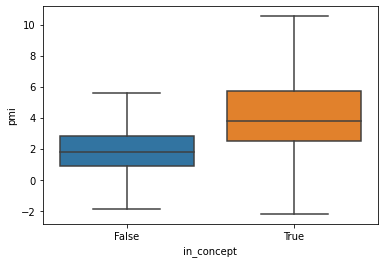

In [24]:
import seaborn as sns
sns.boxplot(x='in_concept', y='pmi', data=data, showfliers=False)

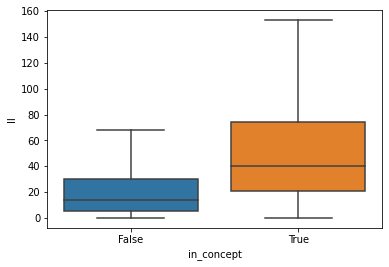

In [25]:
sns.boxplot(x='in_concept', y='ll', data=data, showfliers=False)

In [ ]:
# we can perform t-tests etc.

Conclusion: concept bigrams _do_ have higher association.

## Question 2: How does it look for bigrams in DC's?

In [28]:
disc_concepts = conceptstats.gold_standard_concepts(corpus, continuous=False,
                                                    discontinuous=True)
dc_bigrams = {bigram for concept in disc_concepts for bigram in nltk.bigrams(concept)}

Retrieving gold standard concepts ... Skipped 0 concepts not bounded at tokens boundaries.


In [30]:
import pandas as pd

# now, loop over all bigrams in the n-gram model, measure their association
# and note whether they occur in a concept or not

data_dict = {'bigram': [], 'type': [],  'pmi': [], 'll': [], 'freq': []}

for bigram_pattern, count in model.iterate(2, threshold=FREQ_THRESHOLD,
                                           encoded_patterns=True):
    
    bigram = model.decode_pattern(bigram_pattern)
    data_dict['bigram'].append(bigram)
    
    data_dict['freq'].append(count)
    
    word_a = bigram_pattern[0]
    word_b = bigram_pattern[1]
    contingency_table = model.contingency_table(word_a, word_b, skipgrams=SKIPGRAMS)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)
    
    if bigram in concept_bigrams:
        if bigram in dc_bigrams:
            bigram_type = 'both'
        else:
            bigram_type = 'only_CC'
    elif bigram in dc_bigrams:
        bigram_type = 'only_DC'
    else:
        bigram_type = 'neither'
    
    data_dict['type'].append(bigram_type)


data = pd.DataFrame(data_dict)

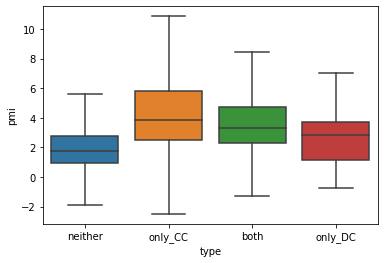

In [31]:
sns.boxplot(x='type', y='pmi', data=data, showfliers=False)

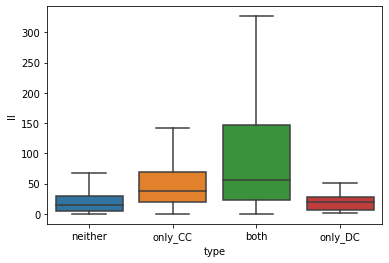

In [32]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

In [33]:
# However, notice that
len(data[data['type'] == 'only_DC'])

16

In [37]:
# compared to e.g.
len(data[data['type'] == 'both'])

786

## Question 3: What is the association across the gap?

In [40]:
from collections import defaultdict

gap_bigrams = defaultdict(list)
cont_bigrams = defaultdict(list)
dc_sample = {dc for doc in corpus for dc in doc.get_annotations(anno.DiscontinuousConcept)}
for dc in dc_sample:
    tokens = dc.get_concept_tokens()
    norm_concept = dc.normalized_concept()
    for i in range(len(tokens) - 1):
        t1, t2 = tokens[i], tokens[i+1]
        bigram = norm_concept[i:i + 2]
        if t2.span[0] - t1.span[-1] > 2:
            gap_bigrams[bigram].append(dc)
        else:
            cont_bigrams[bigram].append(dc)

In [43]:
data_dict = {'bigram': [], 'freq': [], 'pmi': [], 'll': [], 'type': []}

all_bigrams = set(gap_bigrams.keys()).union(set(cont_bigrams.keys()))
for bigram in all_bigrams:
    # skip if not frequent enough
    if model.freq(bigram) < FREQ_THRESHOLD:
        continue

    data_dict['bigram'].append(bigram)
    data_dict['freq'].append(model.freq(bigram))

    contingency_table = model.contingency_table(bigram[0], bigram[1],
                                                skipgrams=SKIPGRAMS)
    pmi = conceptstats.pointwise_mutual_information(contingency_table)
    data_dict['pmi'].append(pmi)
    ll = conceptstats.log_likelihood_ratio(contingency_table)
    data_dict['ll'].append(ll)

    # how it occurs
    if bigram in gap_bigrams:
        if bigram in cont_bigrams: 
            type_ = 'both'
        else:
            type_ = 'only_gap'
    else:
        type_ = 'only_cont'
    data_dict['type'].append(type_)

data = pd.DataFrame(data_dict)

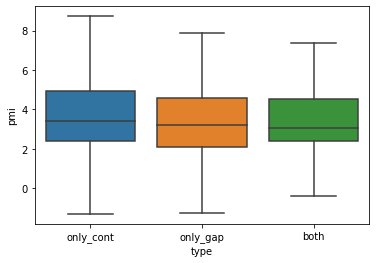

In [44]:
sns.boxplot(x='type', y='pmi', data=data, showfliers=False)

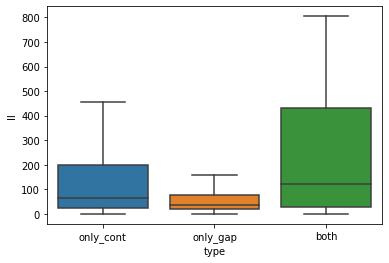

In [50]:
sns.boxplot(x='type', y='ll', data=data, showfliers=False)

In [48]:
data[data['type'] == 'only_cont']

,bigram,freq,pmi,ll,type
0,"(colony-stimulating, factor)",78,5.191534,808.426385,only_cont
5,"(virus, production)",7,2.732866,29.021213,only_cont
6,"(human, jurkat)",17,2.519832,58.734872,only_cont
11,"(signaling, pathway)",122,5.639985,1225.102647,only_cont
13,"(inflammatory, arthritis)",3,6.228488,42.803696,only_cont
...,...,...,...,...,...
790,"(cytokine, production)",44,4.426544,318.624281,only_cont
796,"((, hhv-6)",5,2.718137,22.511221,only_cont
798,"(class, of)",21,0.552837,5.963524,only_cont
799,"(culture, human)",9,2.242201,27.398586,only_cont
